# Extract GPS data from dashcam footage

In [18]:
# file = "241026_140424_073_FH.MP4"
# file = "241026_134333_062_FH.MP4"
file = "241026_142006_087_FH.MP4"
# file = "241026_142106_088_FH.MP4"
# file = "241113_214718_002_FH.MP4"
# file = "241114_110018_009_FH.MP4"
min_string_length = 9

In [19]:
import re
import numpy as np

In [20]:
!echo"hi"& firefox {file}

/bin/bash: line 1: echohi: command not found
Gtk-Message: 11:51:12.376: Not loading module "atk-bridge": The functionality is provided by GTK natively. Please try to not load it.
[7397, Main Thread] WARNING: GTK+ module /snap/firefox/5273/gnome-platform/usr/lib/gtk-2.0/modules/libcanberra-gtk-module.so cannot be loaded.
GTK+ 2.x symbols detected. Using GTK+ 2.x and GTK+ 3 in the same process is not supported.: 'glib warning', file /build/firefox/parts/firefox/build/toolkit/xre/nsSigHandlers.cpp:187

(firefox:7397): Gtk-WARNING **: 11:51:12.441: GTK+ module /snap/firefox/5273/gnome-platform/usr/lib/gtk-2.0/modules/libcanberra-gtk-module.so cannot be loaded.
GTK+ 2.x symbols detected. Using GTK+ 2.x and GTK+ 3 in the same process is not supported.
Gtk-Message: 11:51:12.441: Failed to load module "canberra-gtk-module"
[7397, Main Thread] WARNING: GTK+ module /snap/firefox/5273/gnome-platform/usr/lib/gtk-2.0/modules/libcanberra-gtk-module.so cannot be loaded.
GTK+ 2.x symbols detected. Usi

# Read file contents

In [21]:
def getStringsFromFile(file):
    strings = ""
    with open(file, "rb") as f:
        strings = f.read()

    pattern = rb'\$[GPRMC|GPGGA][ -~]{' + str(min_string_length).encode() + rb',}'
    strings = re.findall(pattern, strings)    
    return [s.decode('utf-8', errors='ignore') for s in strings]

In [22]:
data = getStringsFromFile(file)

data = [s for s in data if s ]

data[:5]

['$GPRMC,132007.300,A,5304.44085,N,00228.74010,W,22.958,40.48,261024,,,A*5C',
 '$GPGGA,132007.300,5304.44085,N,00228.74010,W,1,13,0.83,46.8,M,49.8,M,,*57',
 '$GPRMC,132007.400,A,5304.44133,N,00228.73943,W,22.779,40.11,261024,,,A*5E',
 '$GPGGA,132007.400,5304.44133,N,00228.73943,W,1,12,0.91,46.8,M,49.8,M,,*56',
 '$GPRMC,132007.500,A,5304.44182,N,00228.73877,W,23.068,39.36,261024,,,A*5E']

In [23]:
def parse_gprmc(sentence):
    # $GPRMC,<time>,<status>,<latitude>,<N/S>,<longitude>,<E/W>,<speed>,<course>,<date>,<magnetic variation>,<E/W>,<checksum>
    parts = sentence.split(',')
    if len(parts) < 10 or parts[0] != '$GPRMC':
        return None
    
    # Extract latitude and longitude with direction
    latitude = parts[3]
    lat_direction = parts[4]
    longitude = parts[5]
    lon_direction = parts[6]
    speed = parts[7]  # Speed in knots
    
    # Return the extracted values as a dictionary
    return {
        "latitude": latitude + ' ' + lat_direction,
        "longitude": longitude + ' ' + lon_direction,
        "speed": speed
    }

In [24]:
positions = []
for sentence in data:
    lat_lon = parse_gprmc(sentence)
    if lat_lon:
        positions.append(lat_lon)

print(f"Found {len(positions)} positions")
positions[:5]

Found 659 positions


[{'latitude': '5304.44085 N', 'longitude': '00228.74010 W', 'speed': '22.958'},
 {'latitude': '5304.44133 N', 'longitude': '00228.73943 W', 'speed': '22.779'},
 {'latitude': '5304.44182 N', 'longitude': '00228.73877 W', 'speed': '23.068'},
 {'latitude': '5304.44230 N', 'longitude': '00228.73811 W', 'speed': '22.790'},
 {'latitude': '5304.44278 N', 'longitude': '00228.73743 W', 'speed': '22.844'}]

## Plot on graph

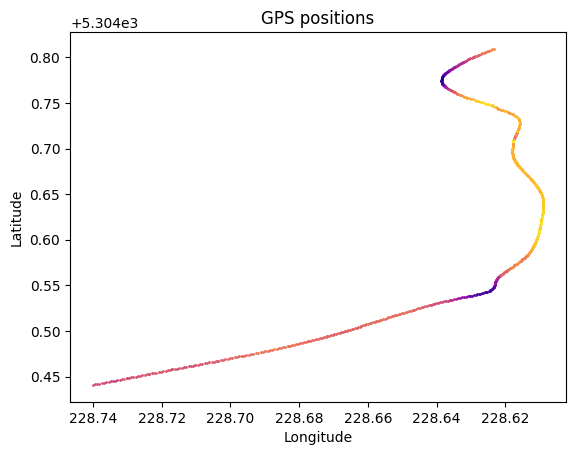

In [40]:
from matplotlib import pyplot as plt

longitudes = [float(pos['longitude'].split()[0]) for pos in positions]
latitudes = [float(pos['latitude'].split()[0]) for pos in positions]
speeds = [pos['speed'] for pos in positions]

norm = plt.Normalize(min(speeds), max(speeds))
cmap = plt.cm.plasma

for lon, lat, speed in zip(longitudes, latitudes, speeds):
    plt.scatter(lon, lat, color=cmap(norm(float(speed))), s=1)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
# flip axis to show the map in the correct orientation
plt.gca().invert_xaxis()
plt.title('GPS positions')
# show heat map of point concentration
plt.show()

# Find bends

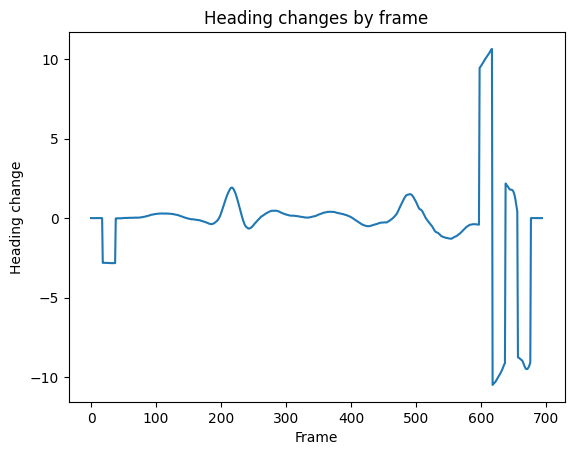

In [26]:
from numpy import average


def find_bends(positions):
    headings = []

    for i in range(1, len(positions)):
        lat1, lon1 = positions[i-1]
        lat2, lon2 = positions[i]
        if lat1 == lat2 and lon1 == lon2:
            continue

        # Calculate the heading from the first to the second position
        heading = np.arctan2(lon2 - lon1, lat2 - lat1) * 180 / np.pi
        headings.append(heading)

    # Calculate the difference between consecutive headings
    bends = np.diff(headings)
    return bends
average_window = 20

smooth_latitudes = np.convolve(latitudes, np.ones(average_window)/average_window)
smooth_longitudes = np.convolve(longitudes, np.ones(average_window)/average_window)

bends = find_bends(list(zip(smooth_latitudes, smooth_longitudes)))

smooth_bends = np.convolve(bends, np.ones(average_window)/average_window)


plt.title('Heading changes by frame')
plt.xlabel('Frame')
plt.ylabel('Heading change')
plt.plot(smooth_bends)

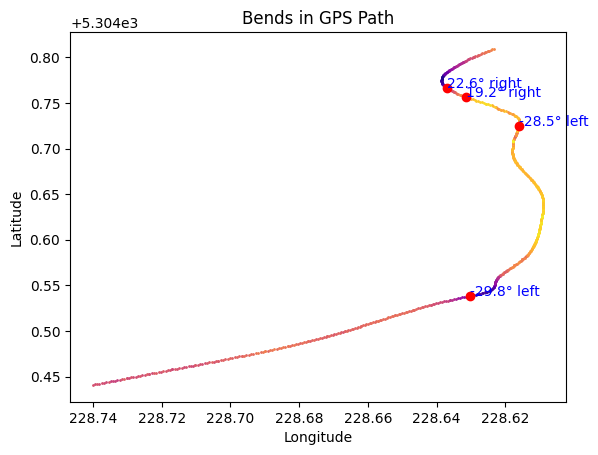

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

## Step 1: Compute vector differences
diff_lon = np.diff(longitudes)
diff_lat = np.diff(latitudes)
vectors = np.vstack((diff_lon, diff_lat)).T

# Step 2: Compute angles between consecutive vectors
angles = []
forward_window = 40 # consider current vector window head
backward_window = 5

for i in range(backward_window , len(vectors) - (forward_window+backward_window)):
    v1 = vectors[i:i + backward_window].mean(axis=0)
    v2 = vectors[i + backward_window:i + forward_window].mean(axis=0)
    cos_theta = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
    angle = np.arccos(np.clip(cos_theta, -1.0, 1.0))

    # Calculate cross product to determine direction
    cross_product = np.cross([*v1, 0], [*v2, 0])[2]
    if cross_product < 0:
        angle = -angle
    angles.append(np.degrees(angle))

# Detect bends based on angle threshold
lower_threshold = 20  # degrees, for example
bends = np.where(abs(np.array(angles)) > lower_threshold)[0]

# Sum clusters
bends = np.split(bends, np.where(np.diff(bends) != 1)[0] + 1)
bends = [int(np.mean(bend)) for bend in bends]

# ignore last bend due to noisy data
bends = bends[:-1]

# Shift bends to account for the forward window
bends = [bend + backward_window for bend in bends]

for lon, lat, speed in zip(longitudes, latitudes, speeds):
    plt.scatter(lon, lat, color=cmap(norm(float(speed))), s=1)
   
# Plot and annotate bends
for bend in bends:
    plt.scatter(longitudes[bend], latitudes[bend], color='red')
    direction = "left" if angles[bend] < 0 else "right"
    plt.text(longitudes[bend], latitudes[bend], f"{angles[bend]:.1f}° {direction}", color='blue')

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Bends in GPS Path")
plt.gca().invert_xaxis()
plt.show()


In [28]:
bends

[185, 459, 506, 522]

In [29]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

cap = cv2.VideoCapture(file, cv2.CAP_FFMPEG)

total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
frame_rate = cap.get(cv2.CAP_PROP_FPS)

print(f"Total frames: {total_frames}")
print(f"Frame rate: {frame_rate}")

Total frames: 1800
Frame rate: 29.97002997002997


In [30]:
def get_frame_number_based_on_bend_long_lat(bends, longitudes, latitudes):
    frame_numbers = []
    for bend in bends:
        for i in range(len(longitudes)):
            if longitudes[i] == longitudes[bend] and latitudes[i] == latitudes[bend]:
                frame_numbers.append(i)
                break
    return frame_numbers

frame_numbers = get_frame_number_based_on_bend_long_lat(bends, longitudes, latitudes)

frame_numbers = [int(frame_number*(frame_rate/10)) for frame_number in frame_numbers]

frame_numbers

[554, 1375, 1516, 1564]

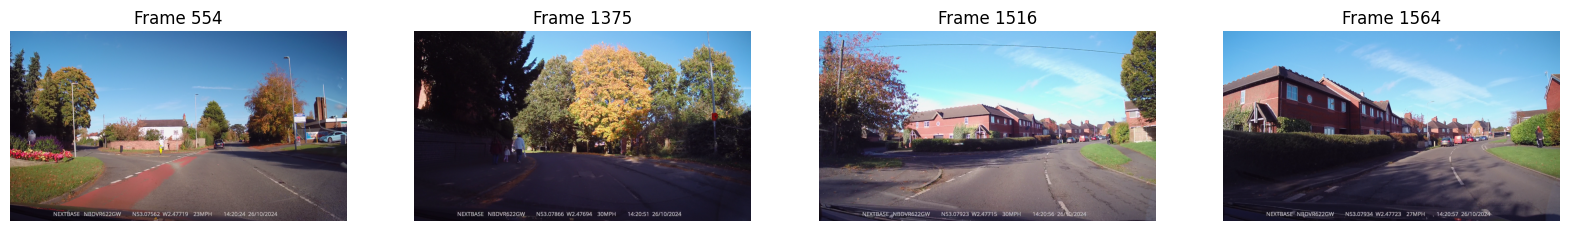

Total frames: 1800


In [31]:
frames = []

for frame_number in frame_numbers:
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    ret, frame = cap.read()
    if ret:
        frames.append(frame)
    else:
        print(f"Warning: Could not read frame {frame_number}")
 
cap.release()

fig, axes = plt.subplots(1, len(frames), figsize=(20, 10))
for i, frame in enumerate(frames):
    axes[i].imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    axes[i].axis('off')
    axes[i].set_title(f"Frame {frame_numbers[i]}")

plt.show()

print(f"Total frames: {total_frames}")